In [1]:
from imputationLibrary import forwardFilling, hotDeck, meanImputation, movingAverage, splineInterpolation, randomSampleImputation, util
from imputationLibrary.util import util
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy import signal
import matplotlib.pyplot as plt

In [52]:
INPUT = 'output/\CompleteWeeklyIndexes'

In [53]:
def calc_acc(col):
    normalized = preprocessing.normalize([np.array(col.fillna(0))])
    corr = signal.correlate(normalized, normalized, mode='full')
    return pd.Series(corr.T[-len(col.index):].reshape(-1), index = col.index)

In [61]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0).drop('vix_Close', axis=1)
df_train = df.loc['2000-01-01':'2015-01-01']
df_test = df.loc['2015-01-02':]

In [62]:
trend_seasonal_train = util.generate_trend_and_seasonal(df_train.index).rename("trend_seasonal")
trend_train = util.generate_trended(df_train.index).rename("trend")
seasonal_train = util.generate_seasonal(df_train.index).rename("seasonal")
white_noise_train = util.generate_white_noise(df_train.index).rename("white_noise")

#trend_seasonal_test = util.generate_trend_and_seasonal(df_test.index).rename(columns={"0": "trend_seasonal"})
#trend_test = util.generate_trended(df_test.index)
#seasonal_test = util.generate_seasonal(df_test.index)
#white_noise_test = util.generate_white_noise(df_test.index)

In [63]:
type(trend_seasonal_train)

pandas.core.series.Series

In [64]:
df_train = pd.concat([df_train, trend_seasonal_train, trend_train, seasonal_train, white_noise_train], axis=1, join='outer')
df_test = pd.concat([df_test, trend_seasonal_test, trend_test, seasonal_test, white_noise_test], axis=1, join='outer')

In [65]:
df_train.columns

Index(['sp500_Close', 'sp500_Volume', 'vix_Volume', 'dji_Close', 'dji_Volume',
       'ndx_Close', 'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close',
       'ftse_Volume', 'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume',
       'Overall EMV Tracker', 'infectious_daily_infect_emv_index', 'GPR',
       'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty',
       'trade_Trade Policy EMV Fraction', 'trend_seasonal', 'trend',
       'seasonal', 'white_noise'],
      dtype='object')

In [66]:
df_train_acc = df_train.apply(calc_acc)
df_train_T = df_train_acc.transpose()

In [67]:
df_train_0_imp = df_train_T.fillna(0)
scaler = preprocessing.StandardScaler()
scaler.fit(df_train_0_imp)
array = scaler.transform(df_train_0_imp)
df_scaled = pd.DataFrame(data=array, index=df_train_T.index, columns=df_train_T.columns)

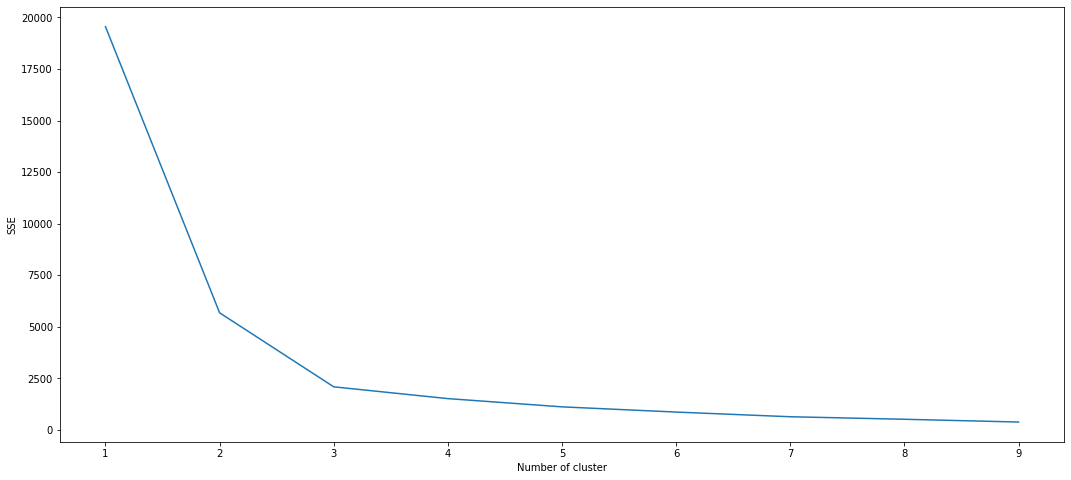

In [68]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_scaled)

    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(18,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [69]:
# Tem um joelho em 2 e em 3

In [70]:
#kmeans_5 = KMeans(init="k-means++", n_clusters=5, n_init=4,
#                random_state=0).fit(df_scaled)
kmeans_4 = KMeans(init="k-means++", n_clusters=4, n_init=4,
                random_state=0).fit(df_scaled)
kmeans_3 = KMeans(init="k-means++", n_clusters=3, n_init=4,
                random_state=0).fit(df_scaled)
kmeans_2 = KMeans(init="k-means++", n_clusters=2, n_init=4,
                random_state=0).fit(df_scaled)

In [71]:
#df_train_T["clusters_5"] = kmeans_5.labels_
df_train_T["clusters_4"] = kmeans_4.labels_
df_train_T["clusters_3"] = kmeans_3.labels_
df_train_T["clusters_2"] = kmeans_2.labels_

In [72]:
#print("Cluster 1 ", df_train_T[df_train_T['clusters_5'] == 0].index)
#print("Cluster 2 ", df_train_T[df_train_T['clusters_5'] == 1].index)
#print("Cluster 3 ", df_train_T[df_train_T['clusters_5'] == 2].index)
#print("Cluster 4 ", df_train_T[df_train_T['clusters_5'] == 3].index)
#print("Cluster 5 ", df_train_T[df_train_T['clusters_5'] == 4].index)

In [73]:
print("Cluster 1 ", df_train_T[df_train_T['clusters_4'] == 0].index)
print("Cluster 2 ", df_train_T[df_train_T['clusters_4'] == 1].index)
print("Cluster 3 ", df_train_T[df_train_T['clusters_4'] == 2].index)
print("Cluster 4 ", df_train_T[df_train_T['clusters_4'] == 3].index)

Cluster 1  Index(['sp500_Close', 'dji_Close', 'ndx_Close', 'ndx_Volume', 'n225_Close',
       'ftse_Close', 'hsi_Close', 'n100_Close'],
      dtype='object')
Cluster 2  Index(['vix_Volume', 'Overall EMV Tracker',
       'infectious_daily_infect_emv_index', 'GPR',
       'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty',
       'trade_Trade Policy EMV Fraction', 'seasonal', 'white_noise'],
      dtype='object')
Cluster 3  Index(['sp500_Volume', 'dji_Volume', 'n225_Volume', 'ftse_Volume',
       'trend_seasonal', 'trend'],
      dtype='object')
Cluster 4  Index(['hsi_Volume', 'n100_Volume'], dtype='object')


In [74]:
print("Cluster 1 ", df_train_T[df_train_T['clusters_3'] == 0].index)
print("Cluster 2 ", df_train_T[df_train_T['clusters_3'] == 1].index)
print("Cluster 3 ", df_train_T[df_train_T['clusters_3'] == 2].index)

Cluster 1  Index(['sp500_Close', 'dji_Close', 'ndx_Close', 'ndx_Volume', 'n225_Close',
       'ftse_Close', 'hsi_Close', 'n100_Close'],
      dtype='object')
Cluster 2  Index(['vix_Volume', 'Overall EMV Tracker',
       'infectious_daily_infect_emv_index', 'GPR',
       'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty',
       'trade_Trade Policy EMV Fraction', 'seasonal', 'white_noise'],
      dtype='object')
Cluster 3  Index(['sp500_Volume', 'dji_Volume', 'n225_Volume', 'ftse_Volume',
       'hsi_Volume', 'n100_Volume', 'trend_seasonal', 'trend'],
      dtype='object')


In [75]:
print("Cluster 1 ", df_train_T[df_train_T['clusters_2'] == 0].index)
print("Cluster 2 ", df_train_T[df_train_T['clusters_2'] == 1].index)

Cluster 1  Index(['vix_Volume', 'hsi_Volume', 'n100_Volume', 'Overall EMV Tracker',
       'infectious_daily_infect_emv_index', 'GPR',
       'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty',
       'trade_Trade Policy EMV Fraction', 'seasonal', 'white_noise'],
      dtype='object')
Cluster 2  Index(['sp500_Close', 'sp500_Volume', 'dji_Close', 'dji_Volume', 'ndx_Close',
       'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume',
       'hsi_Close', 'n100_Close', 'trend_seasonal', 'trend'],
      dtype='object')


In [ ]:
# talvez inputar com todas as combinações possiveis e ver qual a melhor??? muitas combinações, dificil para ajustar os parametros separadamente
# fazer os testes em cada cluster, a maioria ganha?
